In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,KFold,cross_val_predict,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc
import sklearn.metrics as skm
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [2]:
#import the reference data with the unknown sample (optional) in the last row
data = pd.read_csv("C:/Users/user/OneDrive/DESKTOP/testaki_admixed2.csv")

In [3]:
data

,rs10497191,rs1079597,rs11652805,rs1229984,rs12439433,rs12498138,rs12913832,rs1426654,rs1462906,rs1572018,...,rs735480,rs7554936,rs7657799,rs7722456,rs798443,rs7997709,rs870347,rs917115,rs9522149,label
0,CT,CT,CT,TT,AA,GG,AA,GG,CC,TT,...,TT,CT,GG,TT,AA,TT,AA,CT,TT,East_Asian
1,CC,TT,TT,CT,AA,AG,AA,GG,CC,TT,...,CT,TT,GT,TT,AA,TT,CC,CC,TT,East_Asian
2,CC,CT,CT,CT,AA,GG,AA,GG,CC,TT,...,CT,TT,TT,TT,AA,CT,AC,CC,TT,East_Asian
3,CC,CC,CC,CT,AA,GG,AA,GG,CC,CT,...,TT,TT,TT,TT,AG,CT,AA,CC,TT,East_Asian
4,CC,CC,TT,CT,AA,GG,AA,GG,CC,CT,...,CT,TT,TT,TT,AG,TT,AC,CC,TT,East_Asian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,CC,CC,TT,CC,AA,GG,AA,AG,CC,CT,...,CT,TT,TT,CT,AA,TT,AA,CC,TT,EUR/OCE
2048,CC,CT,TT,CC,AA,GG,AG,AG,CC,CT,...,CT,CT,TT,CT,AA,TT,AA,CC,CT,EUR/OCE
2049,CC,CC,TT,CT,AA,GG,AG,AG,CC,CT,...,CT,TT,TT,CT,AA,TT,AC,CC,TT,EUR/OCE
2050,CC,CT,TT,CC,AA,GG,AG,AG,CC,TT,...,CT,CT,TT,CT,AA,TT,AA,CT,CT,EUR/OCE


In [4]:
#function that gets the unknown sample from the last row and stores it in a new dataframe for predicting after training
def get_unknown_sample(data):
    data_nolabel=data.drop('label',axis=1)
    cols=data_nolabel.columns 
    data_nolabel_onehot_sample=pd.get_dummies(data_nolabel, columns=cols)
    sample = data_nolabel_onehot_sample.iloc[-1,:]
    sample = pd.DataFrame(sample)
    new_sample=sample.T
    new_sample=new_sample.reset_index(drop=True)
    return new_sample

In [5]:
new_sample=get_unknown_sample(data)
new_sample

,rs10497191_CC,rs10497191_CT,rs10497191_TT,rs1079597_CC,rs1079597_CT,rs1079597_TT,rs11652805_CC,rs11652805_CT,rs11652805_TT,rs1229984_CC,...,rs7997709_TT,rs870347_AA,rs870347_AC,rs870347_CC,rs917115_CC,rs917115_CT,rs917115_TT,rs9522149_CC,rs9522149_CT,rs9522149_TT
0,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,0,1,0,0,1,0


In [6]:
#function that returns the one hot encoded data from the raw genotype data
def get_data_nolabel(data):
    data2 = data.drop(data.tail(1).index, axis=0)
    data3=data2.drop(('label'), axis=1)
    x=data3.columns
    new_data=pd.get_dummies(data3, columns=x)
    return new_data

In [7]:
new_data=get_data_nolabel(data)
new_data

,rs10497191_CC,rs10497191_CT,rs10497191_TT,rs1079597_CC,rs1079597_CT,rs1079597_TT,rs11652805_CC,rs11652805_CT,rs11652805_TT,rs1229984_CC,...,rs7997709_TT,rs870347_AA,rs870347_AC,rs870347_CC,rs917115_CC,rs917115_CT,rs917115_TT,rs9522149_CC,rs9522149_CT,rs9522149_TT
0,0,1,0,0,1,0,0,1,0,0,...,1,1,0,0,0,1,0,0,0,1
1,1,0,0,0,0,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
2,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,1,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1,0,0,1,0,0,0,0,1,1,...,1,1,0,0,0,1,0,0,0,1
2047,1,0,0,1,0,0,0,0,1,1,...,1,1,0,0,1,0,0,0,0,1
2048,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,1,0,0,0,1,0
2049,1,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1


In [8]:
#All columns except for the label column
X=new_data.iloc[:,:]
X

,rs10497191_CC,rs10497191_CT,rs10497191_TT,rs1079597_CC,rs1079597_CT,rs1079597_TT,rs11652805_CC,rs11652805_CT,rs11652805_TT,rs1229984_CC,...,rs7997709_TT,rs870347_AA,rs870347_AC,rs870347_CC,rs917115_CC,rs917115_CT,rs917115_TT,rs9522149_CC,rs9522149_CT,rs9522149_TT
0,0,1,0,0,1,0,0,1,0,0,...,1,1,0,0,0,1,0,0,0,1
1,1,0,0,0,0,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
2,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,1,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1,0,0,1,0,0,0,0,1,1,...,1,1,0,0,0,1,0,0,0,1
2047,1,0,0,1,0,0,0,0,1,1,...,1,1,0,0,1,0,0,0,0,1
2048,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,1,0,0,0,1,0
2049,1,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1


In [9]:
#Only the label column
Y=data.iloc[:,-1]
Y = Y.drop(data.tail(1).index, axis=0)
Y

0       East_Asian
1       East_Asian
2       East_Asian
3       East_Asian
4       East_Asian
           ...    
2046       EUR/OCE
2047       EUR/OCE
2048       EUR/OCE
2049       EUR/OCE
2050       EUR/OCE
Name: label, Length: 2051, dtype: object

In [10]:
#XGBoost cannot handle categorical labels, so they are transfmormed to numbers 
k=0
for i in Y:
    if i == 'South_Asian':
        Y[k]=0
        k=k+1
    elif i == 'European':
        Y[k]=1
        k=k+1
    elif i == 'EUR/SAS':
        Y[k]=2
        k=k+1
    elif i == 'East_Asian':
        Y[k]=3
        k=k+1
    elif i == 'EUR/EAS':
        Y[k]=4
        k=k+1
    elif i == 'Native_American':
        Y[k]=5
        k=k+1
    elif i == 'EUR/NAM':
        Y[k]=6
        k=k+1
    elif i == 'Oceanian':
        Y[k]=7
        k=k+1
    elif i == 'EUR/OCE':
        Y[k]=8
        k=k+1
    elif i == 'Sub_Saharan_African':
        Y[k]=9
        k=k+1
    else:
        Y[k]=10
        k=k+1
Yx = np.array(Y)
Yx=Yx.astype('int')

In [11]:
Yx

array([3, 3, 3, ..., 8, 8, 8])

In [12]:
#defining the inner and outer loop of the nested cross validation scheme
outer_kf = StratifiedKFold(n_splits=5,shuffle=True, random_state=1)
inner_kf = StratifiedKFold(n_splits=3,shuffle=True, random_state=2)

In [13]:
#search space for GridSearchCV (inner loop)
params = { 'max_depth': [6,8,10],
           'learning_rate': [0.02,0.03,0.04],
           'n_estimators': [400,600,800],
           'colsample_bytree': [0.2,0.3]}
xgbc = xgb.XGBClassifier(seed = 20)

{'colsample_bytree': 0.2, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 600}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        67
           1       0.99      1.00      0.99        99
           2       1.00      0.70      0.82        10
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00         8
           5       0.88      1.00      0.93         7
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00       100
          10       1.00      1.00      1.00        10

    accuracy                           0.99       411
   macro avg       0.99      0.94      0.96       411
weighted avg       0.99      0.99      0.99       411



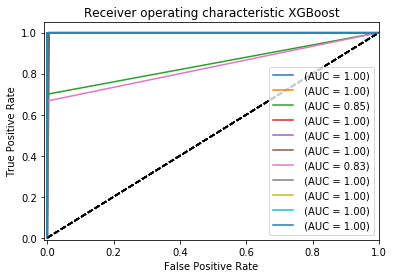

{'colsample_bytree': 0.2, 'learning_rate': 0.04, 'max_depth': 10, 'n_estimators': 800}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       0.98      1.00      0.99       100
           2       1.00      0.70      0.82        10
           3       1.00      1.00      1.00        99
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00       100
          10       1.00      1.00      1.00        10

    accuracy                           0.99       410
   macro avg       1.00      0.97      0.98       410
weighted avg       0.99      0.99      0.99       410



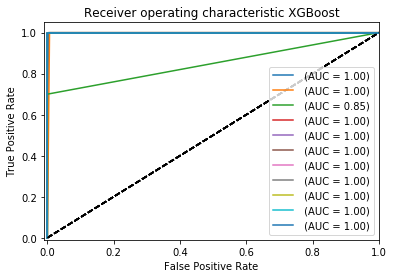

{'colsample_bytree': 0.2, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 800}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        68
           1       0.98      1.00      0.99       100
           2       0.86      0.60      0.71        10
           3       1.00      1.00      1.00        99
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        99
          10       1.00      1.00      1.00        10

    accuracy                           0.99       410
   macro avg       0.98      0.96      0.97       410
weighted avg       0.99      0.99      0.99       410



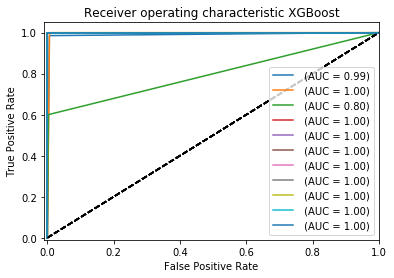

{'colsample_bytree': 0.2, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 800}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       0.97      1.00      0.99        99
           2       1.00      0.70      0.82        10
           3       1.00      1.00      1.00        99
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00        99
          10       1.00      1.00      1.00        10

    accuracy                           0.99       410
   macro avg       1.00      0.95      0.97       410
weighted avg       0.99      0.99      0.99       410



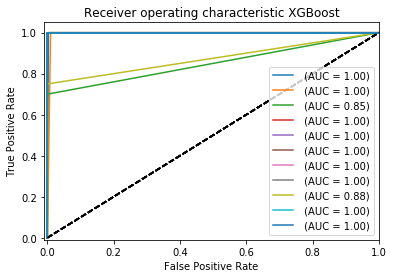

{'colsample_bytree': 0.2, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 600}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        68
           1       0.98      1.00      0.99        99
           2       1.00      0.50      0.67        10
           3       1.00      1.00      1.00        99
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        99
          10       1.00      1.00      1.00        10

    accuracy                           0.99       410
   macro avg       0.99      0.95      0.97       410
weighted avg       0.99      0.99      0.99       410



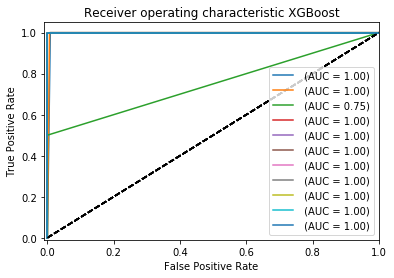

(0.9902676399026764, 0.9859741112026303, {'objective': 'multi:softprob', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.2, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.03, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 8, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 600, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 20, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': None, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'seed': 20})
(0.9926829268292683, 0.9859841560024375, {'objective': 'multi:softprob', 'use_label_encoder': False, 'bas

In [14]:
#nested cross validation scheme
from matplotlib import pyplot as plt2
outer_loop_accuracy_scores = []
inner_loop_won_params = []
inner_loop_accuracy_scores = []
best_param = []
xtrain,ytrain,xtest,ytest=[],[],[],[]
k=1

# Looping through the outer loop, feeding each training set into a GSCV as the inner loop
for train_index,test_index in outer_kf.split(X,Yx):

    GSCV = GridSearchCV(xgbc,params,cv=inner_kf)
    
    # GSCV is looping through the training data to find the best parameters. This is the inner loop
    GSCV.fit(X.iloc[train_index],Yx[train_index])
    xtrain.append(X.iloc[train_index])
    ytrain.append(Yx[train_index])
  
    # The best hyper parameters from GSCV is now being tested on the unseen outer loop test data.
    pred = GSCV.predict(X.iloc[test_index])
    xtest.append(X.iloc[test_index])
    print(GSCV.best_params_)

    # Appending the "winning" hyper parameters and their associated accuracy score
    inner_loop_won_params.append(GSCV.best_estimator_.get_params())

    outer_loop_accuracy_scores.append(accuracy_score(Yx[test_index],pred))
    print(skm.classification_report(Yx[test_index],pred))
    ytest.append(Yx[test_index])
    inner_loop_accuracy_scores.append(GSCV.best_score_)
    
    
    class_list = [0,1,2,3,4,5,6,7,8,9,10]
    y = label_binarize(Yx[test_index], classes=class_list)
    bin_pred = label_binarize(pred, classes= class_list)
    n_classes = 11

    # Compute ROC curve and ROC area for each class (Onevs.Rest scheme)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], bin_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        #plt.figure()
        plt.plot(fpr[i], tpr[i], label=' (AUC = %0.2f)' % (roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic XGBoost')
    plt.legend(loc="lower right")
    plt2.savefig('rocxgb{0}.jpg'.format(k))
    plt.show()
    k=k+1


for i in zip(outer_loop_accuracy_scores,inner_loop_accuracy_scores, inner_loop_won_params):
    print(i)

print('Mean of outer loop accuracy score:',np.mean(outer_loop_accuracy_scores))

In [15]:
GSCV.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.03,
 'max_depth': 8,
 'n_estimators': 600}

In [60]:
#create a new xgboost object for final predicitons selecting a "concensus" model from the above
clf_final = xgb.XGBClassifier(colsample_bytree= 0.2,learning_rate= 0.03,max_depth= 8,n_estimators= 800)

In [61]:
clf_final.fit(xtrain[3],ytrain[3])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [62]:
a=clf_final.predict(xtest[3])

In [63]:
print(skm.classification_report(ytest[3],a))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        68
           1       0.97      1.00      0.99        99
           2       1.00      0.60      0.75        10
           3       0.99      1.00      0.99        99
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      0.75      0.86         4
           9       1.00      1.00      1.00        99
          10       1.00      1.00      1.00        10

    accuracy                           0.99       410
   macro avg       0.99      0.93      0.96       410
weighted avg       0.99      0.99      0.98       410



In [45]:
ytrain[3]

array([3, 3, 3, ..., 8, 8, 8])

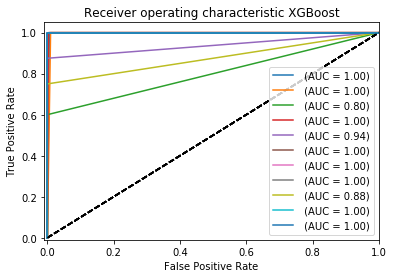

In [46]:
    class_list = [0,1,2,3,4,5,6,7,8,9,10]
    y = label_binarize(ytest[3], classes=class_list)
    bin_pred = label_binarize(a, classes= class_list)
    n_classes = 11

    # Compute ROC curve and ROC area for each class (Onevs.Rest scheme)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], bin_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        #plt.figure()
        plt.plot(fpr[i], tpr[i], label=' (AUC = %0.2f)' % (roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic XGBoost')
    plt.legend(loc="lower right")
    plt2.savefig('rocxgb_fin.jpg')
    plt.show()
    k=k+1


In [47]:
clf_final.predict_proba(new_sample)

array([[4.1779131e-04, 5.2026741e-04, 4.4252216e-03, 1.3818074e-04,
        3.2033555e-03, 3.9293419e-04, 7.5727375e-04, 3.8648702e-04,
        9.8896581e-01, 3.4645729e-04, 4.4616094e-04]], dtype=float32)